In [ ]:
import pandas as pd
import numpy as np
import os
np.random.seed(42)
%load_ext autoreload
%autoreload 2

# === Paths ===
path_in = os.path.join("../Data")  # parent directory

###################### ======================== Case Study 2 ======================= ###########################

file_path = os.path.join(path_in, "dataset4.xlsx")
cs2 = pd.read_excel(file_path)
# Rename columns
rename_mapping = {
        'T_ext': 'OUTDOOR_TEMP',
        'heating_total [kW]': 'PHI_H',
        'GHI': 'PYRANOMETER',
        'T_int': 'INDOOR_TEMP'
    }
cs2 = cs2.rename(columns=rename_mapping)
cs2['PHI_H']=cs2['PHI_H']*1000
# Convert 't' to datetime and set as index

cs2['Time'] = pd.to_datetime(cs2['Time'])
cs2 = cs2.set_index('Time')
cs2 = cs2.resample("30min").mean()
cs2_surface_area = 2100  # m² 
# cs2 = cs2.iloc[0:720]

# split_index = int(0.8 * len(cs2))
# end_index = int(len(cs2)) 
# train_cs2 = cs2.iloc[:split_index]
# val_cs2 = cs2.iloc[split_index:end_index]


In [2]:
#### Funtion

def run_case_study(train_df, surface_area, model_type, label, bounds, trials):
    
    model, parameters, initialization, all_trials = train_greybox_model(
        train_df=train_df,
        model_type=model_type,
        bounds=bounds,
        solver_name="ipopt",
        num_trials=trials,
        deltaT=1800,
        show_plot=False
    )

    best_obj = all_trials['Objective'].min()
    mean_obj = all_trials["Objective"].mean()
    std_obj = all_trials["Objective"].std()
    matches = (np.round(all_trials['Objective'], 5) == np.round(best_obj, 5))
    n_matches = matches.sum()
    n_total = len(all_trials)
    success_rate = 100 * n_matches / n_total

    print(f"[{label}] Best Objective achieved in {n_matches} out of {n_total} trials.")
    print(f"[{label}] Success rate: {success_rate:.2f}%")
    print(f"[{label}] Best Objective was equal to {best_obj}")
    print(f"[{label}] Mean RMSE: {mean_obj:.2f}")
    print(f"[{label}] RMSE Std. Dev.: {std_obj:.2f}")
    print("\n")

    return model , all_trials, initialization, parameters

In [11]:
from models import *  
from train import *  
import numpy as np
from simulate import *
from plot import *

train_cs2 = cs2.iloc[:240]
val_cs2 = cs2.iloc[240:-240]
test_cs2= cs2.iloc[240:]
# --- Bounds ---

bounds_cs2 = {
    "R_in_e": (0.001, 1),
    "R_e_a": (0.001, 1),
    "R_in_a": (0.001, 1),
    "C_in": (1e6, 5e8),
    "C_e": (1e6, 5e8),
    "Ain": (0.0001, 0.3 * cs2_surface_area),
    "Ae": (0.0001, 0.3 * cs2_surface_area),
    "fh": (0,1)
}

best_rmse = np.inf
best_params = None
best_initialization = None
best_initialization_validation = None
best_model = None
best_trial_index = -1
all_trials = pd.DataFrame()
solve_time = 0 
param_names = list(bounds_cs2.keys())

for i in range(10):
    model_3r2c_cs2_5days, all_trials_3r2c_cs2_5days, best_initialization_5days, parameters_5days = run_case_study(train_df=train_cs2, surface_area=cs2_surface_area, label="Case Study 2",model_type="4R3C", bounds=bounds_cs2, trials=1)
    last_index = max(model_3r2c_cs2_5days.T_in.index_set())
    # --- Validation Initialization (from last training value) ---
    initialize_validation = {"Tint": model_3r2c_cs2_5days.T_int[last_index](),"Tin": model_3r2c_cs2_5days.T_in[last_index](), "Te": model_3r2c_cs2_5days.T_e[last_index]()}

    # --- Run Simulation and Validation ---
    validation, t_pred_3r2c_cs2_5days, t_true_3r2c_cs2_5days = simulate_and_evaluate(
        val_df=val_cs2,
        param_dict=parameters_5days,
        model_type="4R3C",
        initializations=initialize_validation,
        show_plot=False
    )
    # --- Results ---   
    print(f"Validation RMSE: {validation['RMSE']:.4f}")
    
    if validation['RMSE'] < best_rmse:
        best_rmse=validation['RMSE']
        best_params=parameters_5days
        best_initialization=best_initialization
        best_model=model_3r2c_cs2_5days
        best_trial_index=i
        all_trials=all_trials_3r2c_cs2_5days
        best_initialization_validation = initialize_validation
        

print(f"Best RMSE: {best_rmse:.4f}")

# --- Run Simulation and Validation ---
validation, t_pred_3r2c_cs2_5days, t_true_3r2c_cs2_5days = simulate_and_evaluate(
        val_df=test_cs2,
        param_dict=best_params,
        model_type="4R3C",
        initializations=best_initialization_validation,
        show_plot=True
    )

rmse_3r2c_5days = np.sqrt(mean_squared_error(t_true_3r2c_cs2_5days[-240:], t_pred_3r2c_cs2_5days[-240:]))
print(f"five last days Validation RMSE: {rmse_3r2c_5days:.4f}")

# --- Plot Residuals ---
# plot_residual(t_pred=t_pred_3r2c_cs2_5days, t_true=t_true_3r2c_cs2_5days)


KeyboardInterrupt: 

[Trial 1] RMSE = 0.3389, Init: {'R_in_e': 0.8632403224497179, 'R_e_a': 0.6236748287007303, 'R_in_a': 0.33156712682779654, 'C_in': 32715616.792725794, 'C_e': 156180178.53611544, 'Ain': 204.86556035851845, 'Ae': 459.6519193923625, 'fh': 0.6375574713552131}
 parameters: {'R_int_in': 0.015094453036783978, 'R_in_e': 0.885427258468048, 'R_e_a': 0.005960376149216487, 'R_in_a': 0.11580515520464083, 'C_int': 19771245.247127343, 'C_in': 1875436.8576117156, 'C_e': 50372273.885515526, 'Aint': 1.5735457423676115e-07, 'Ain': 0.6632621776988734, 'Ae': 0.00012495330803620776, 'fh_int': -8.207237328887304e-09, 'fh_in': 0.0012281630047008005, 'fh_e': 0.9987718452025364, 'fh': 0.6375574713552131, 'Objective': 0.3388703950701868, 'Solve_time': 80.62121915817261}

=== Best result ===
Best Trial #: 1
Best RMSE: 0.3389
Best initialization: {'R_in_e': 0.8632403224497179, 'R_e_a': 0.6236748287007303, 'R_in_a': 0.33156712682779654, 'C_in': 32715616.792725794, 'C_e': 156180178.53611544, 'Ain': 204.86556035851845

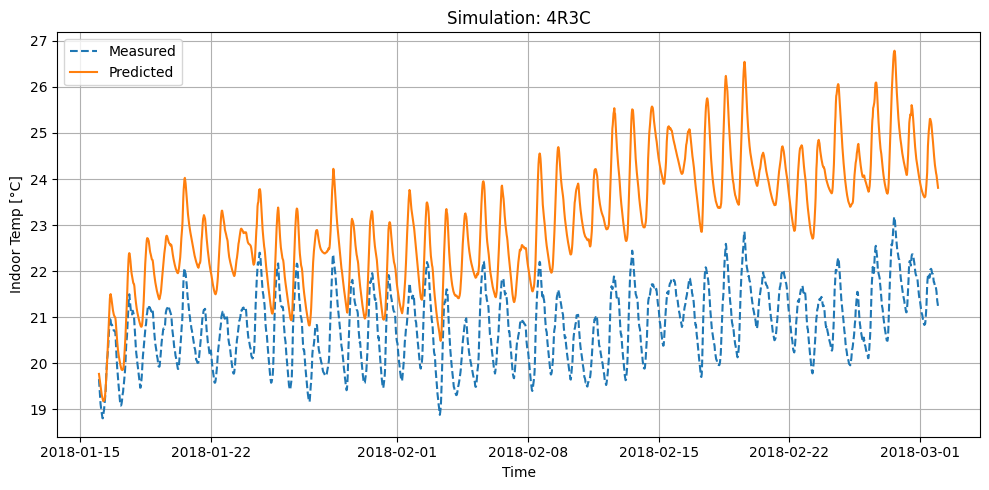

five last days Validation RMSE: 3.1556


In [ ]:
from models import *  
from train import *  
import numpy as np
from simulate import *
from plot import *

train_cs2 = cs2.iloc[:240+480]
val_cs2 = cs2.iloc[240+480:-240]
test_cs2= cs2.iloc[240+480:]
# --- Bounds ---

bounds_cs2 = {
    "R_in_e": (0.001, 1),
    "R_e_a": (0.001, 1),
    "R_in_a": (0.001, 1),
    "C_in": (1e6, 5e8),
    "C_e": (1e6, 5e8),
    "Ain": (0.0001, 0.3 * cs2_surface_area),
    "Ae": (0.0001, 0.3 * cs2_surface_area),
    "fh": (0,1)
}

best_rmse = np.inf
best_params = None
best_initialization = None
best_initialization_validation = None
best_model = None
best_trial_index = -1
all_trials = pd.DataFrame()
solve_time = 0 
param_names = list(bounds_cs2.keys())

for i in range(10):
    model_3r2c_cs2_5days, all_trials_3r2c_cs2_5days, best_initialization_5days, parameters_5days = run_case_study(train_df=train_cs2, surface_area=cs2_surface_area, label="Case Study 2",model_type="4R3C", bounds=bounds_cs2, trials=1)
    last_index = max(model_3r2c_cs2_5days.T_in.index_set())
    # --- Validation Initialization (from last training value) ---
    initialize_validation = {"Tint": model_3r2c_cs2_5days.T_int[last_index](),"Tin": model_3r2c_cs2_5days.T_in[last_index](), "Te": model_3r2c_cs2_5days.T_e[last_index]()}

    # --- Run Simulation and Validation ---
    validation, t_pred_3r2c_cs2_5days, t_true_3r2c_cs2_5days = simulate_and_evaluate(
        val_df=val_cs2,
        param_dict=parameters_5days,
        model_type="4R3C",
        initializations=initialize_validation,
        show_plot=False
    )
    # --- Results ---   
    print(f"Validation RMSE: {validation['RMSE']:.4f}")
    
    if validation['RMSE'] < best_rmse:
        best_rmse=validation['RMSE']
        best_params=parameters_5days
        best_initialization=best_initialization
        best_model=model_3r2c_cs2_5days
        best_trial_index=i
        all_trials=all_trials_3r2c_cs2_5days
        best_initialization_validation = initialize_validation
        

print(f"Best RMSE: {best_rmse:.4f}")

# --- Run Simulation and Validation ---
validation, t_pred_3r2c_cs2_5days, t_true_3r2c_cs2_5days = simulate_and_evaluate(
        val_df=test_cs2,
        param_dict=best_params,
        model_type="4R3C",
        initializations=best_initialization_validation,
        show_plot=True
    )

rmse_3r2c_5days = np.sqrt(mean_squared_error(t_true_3r2c_cs2_5days[-240:], t_pred_3r2c_cs2_5days[-240:]))
print(f"five last days Validation RMSE: {rmse_3r2c_5days:.4f}")

# --- Plot Residuals ---
# plot_residual(t_pred=t_pred_3r2c_cs2_5days, t_true=t_true_3r2c_cs2_5days)


[Trial 1] RMSE = 0.3953, Init: {'R_in_e': 0.368415349586534, 'R_e_a': 0.6326735247629859, 'R_in_a': 0.6338961810501338, 'C_in': 268351567.35330448, 'C_e': 46054595.25714974, 'Ain': 526.2405886909704, 'Ae': 202.09150885418708, 'fh': 0.18651851039985423}
 parameters: {'R_int_in': 0.016671241740298808, 'R_in_e': 0.999999428740734, 'R_e_a': 0.0033446459989527446, 'R_in_a': 0.12915899438120396, 'C_int': 99999941.91348262, 'C_in': 2052582.2602181293, 'C_e': 499999752.0609875, 'Aint': 6.104180661299251e-06, 'Ain': 0.7940634984492282, 'Ae': 0.001928048627175159, 'fh_int': -8.340901548585865e-09, 'fh_in': 0.0009898808956346967, 'fh_e': 0.999010127445267, 'fh': 0.18651851039985423, 'Objective': 0.3953118646704972, 'Solve_time': 630.5620431900024}

=== Best result ===
Best Trial #: 1
Best RMSE: 0.3953
Best initialization: {'R_in_e': 0.368415349586534, 'R_e_a': 0.6326735247629859, 'R_in_a': 0.6338961810501338, 'C_in': 268351567.35330448, 'C_e': 46054595.25714974, 'Ain': 526.2405886909704, 'Ae': 20

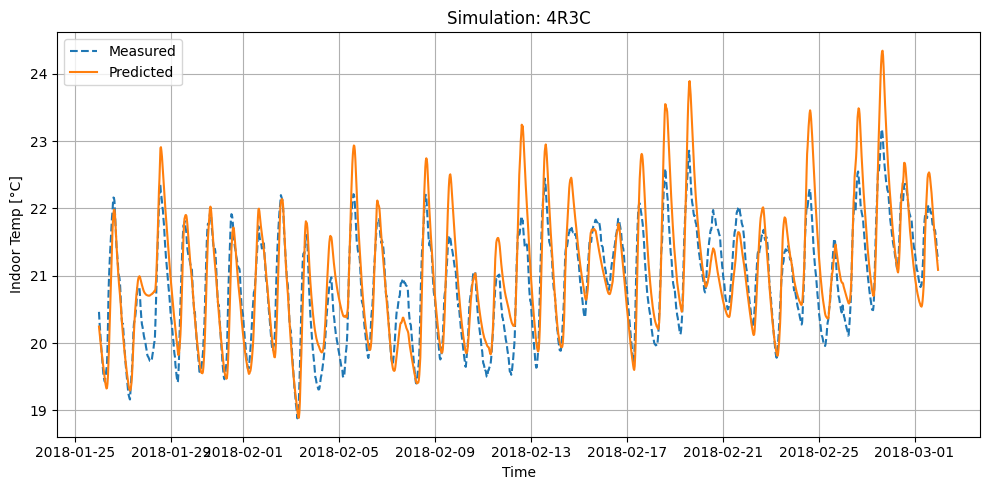

five last days Validation RMSE: 0.4742


In [ ]:
from models import *  
from train import *  
import numpy as np
from simulate import *
from plot import *

train_cs2 = cs2.iloc[:240+480+480]
val_cs2 = cs2.iloc[240+480+480:-240]
test_cs2= cs2.iloc[240+480+480:]
# --- Bounds ---

bounds_cs2 = {
    "R_in_e": (0.001, 1),
    "R_e_a": (0.001, 1),
    "R_in_a": (0.001, 1),
    "C_in": (1e6, 5e8),
    "C_e": (1e6, 5e8),
    "Ain": (0.0001, 0.3 * cs2_surface_area),
    "Ae": (0.0001, 0.3 * cs2_surface_area),
    "fh": (0,1)
}

best_rmse = np.inf
best_params = None
best_initialization = None
best_initialization_validation = None
best_model = None
best_trial_index = -1
all_trials = pd.DataFrame()
solve_time = 0 
param_names = list(bounds_cs2.keys())

for i in range(10):
    model_3r2c_cs2_5days, all_trials_3r2c_cs2_5days, best_initialization_5days, parameters_5days = run_case_study(train_df=train_cs2, surface_area=cs2_surface_area, label="Case Study 2",model_type="4R3C", bounds=bounds_cs2, trials=1)
    last_index = max(model_3r2c_cs2_5days.T_in.index_set())
    # --- Validation Initialization (from last training value) ---
    initialize_validation = {"Tint": model_3r2c_cs2_5days.T_int[last_index](),"Tin": model_3r2c_cs2_5days.T_in[last_index](), "Te": model_3r2c_cs2_5days.T_e[last_index]()}

    # --- Run Simulation and Validation ---
    validation, t_pred_3r2c_cs2_5days, t_true_3r2c_cs2_5days = simulate_and_evaluate(
        val_df=val_cs2,
        param_dict=parameters_5days,
        model_type="4R3C",
        initializations=initialize_validation,
        show_plot=False
    )
    # --- Results ---   
    print(f"Validation RMSE: {validation['RMSE']:.4f}")
    
    if validation['RMSE'] < best_rmse:
        best_rmse=validation['RMSE']
        best_params=parameters_5days
        best_initialization=best_initialization
        best_model=model_3r2c_cs2_5days
        best_trial_index=i
        all_trials=all_trials_3r2c_cs2_5days
        best_initialization_validation = initialize_validation
        

print(f"Best RMSE: {best_rmse:.4f}")

# --- Run Simulation and Validation ---
validation, t_pred_3r2c_cs2_5days, t_true_3r2c_cs2_5days = simulate_and_evaluate(
        val_df=test_cs2,
        param_dict=best_params,
        model_type="4R3C",
        initializations=best_initialization_validation,
        show_plot=True
    )

rmse_3r2c_5days = np.sqrt(mean_squared_error(t_true_3r2c_cs2_5days[-240:], t_pred_3r2c_cs2_5days[-240:]))
print(f"five last days Validation RMSE: {rmse_3r2c_5days:.4f}")

# --- Plot Residuals ---
# plot_residual(t_pred=t_pred_3r2c_cs2_5days, t_true=t_true_3r2c_cs2_5days)


[Trial 1] RMSE = 0.5233, Init: {'R_in_e': 0.37516557872851514, 'R_e_a': 0.9507635921035062, 'R_in_a': 0.7322619478695936, 'C_in': 299730583.6143213, 'C_e': 78853301.58077583, 'Ain': 98.27663221235564, 'Ae': 36.592769857604445, 'fh': 0.8661761457749352}
 parameters: {'R_int_in': 0.014990507037377261, 'R_in_e': 0.13343964636159295, 'R_e_a': 0.004635719322690692, 'R_in_a': 0.0017780079163505786, 'C_int': 64275202.64292337, 'C_in': 375141168.24780506, 'C_e': 214379527.70899042, 'Aint': 5.173799344498838e-06, 'Ain': 94.07519603785543, 'Ae': 0.00025401820237943066, 'fh_int': 8.757193349861631e-08, 'fh_in': 0.17227888850178938, 'fh_e': 0.8277210239262772, 'fh': 0.8661761457749352, 'Objective': 0.5232845557018966, 'Solve_time': 468.82886576652527}

=== Best result ===
Best Trial #: 1
Best RMSE: 0.5233
Best initialization: {'R_in_e': 0.37516557872851514, 'R_e_a': 0.9507635921035062, 'R_in_a': 0.7322619478695936, 'C_in': 299730583.6143213, 'C_e': 78853301.58077583, 'Ain': 98.27663221235564, 'Ae'

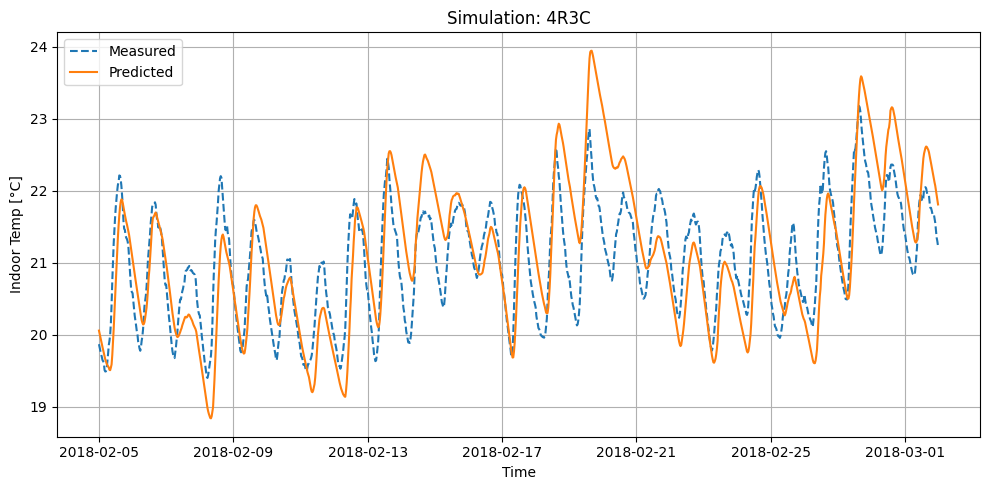

five last days Validation RMSE: 0.6589


In [3]:
from models import *  
from train import *  
import numpy as np
from simulate import *
from plot import *

train_cs2 = cs2.iloc[:240+480+480+480]
val_cs2 = cs2.iloc[240+480+480+480:-240]
test_cs2= cs2.iloc[240+480+480+480:]
# --- Bounds ---

bounds_cs2 = {
    "R_in_e": (0.001, 1),
    "R_e_a": (0.001, 1),
    "R_in_a": (0.001, 1),
    "C_in": (1e6, 5e8),
    "C_e": (1e6, 5e8),
    "Ain": (0.0001, 0.3 * cs2_surface_area),
    "Ae": (0.0001, 0.3 * cs2_surface_area),
    "fh": (0,1)
}

best_rmse = np.inf
best_params = None
best_initialization = None
best_initialization_validation = None
best_model = None
best_trial_index = -1
all_trials = pd.DataFrame()
solve_time = 0 
param_names = list(bounds_cs2.keys())

for i in range(10):
    model_3r2c_cs2_5days, all_trials_3r2c_cs2_5days, best_initialization_5days, parameters_5days = run_case_study(train_df=train_cs2, surface_area=cs2_surface_area, label="Case Study 2",model_type="4R3C", bounds=bounds_cs2, trials=1)
    last_index = max(model_3r2c_cs2_5days.T_in.index_set())
    # --- Validation Initialization (from last training value) ---
    initialize_validation = {"Tint": model_3r2c_cs2_5days.T_int[last_index](),"Tin": model_3r2c_cs2_5days.T_in[last_index](), "Te": model_3r2c_cs2_5days.T_e[last_index]()}

    # --- Run Simulation and Validation ---
    validation, t_pred_3r2c_cs2_5days, t_true_3r2c_cs2_5days = simulate_and_evaluate(
        val_df=val_cs2,
        param_dict=parameters_5days,
        model_type="4R3C",
        initializations=initialize_validation,
        show_plot=False
    )
    # --- Results ---   
    print(f"Validation RMSE: {validation['RMSE']:.4f}")
    
    if validation['RMSE'] < best_rmse:
        best_rmse=validation['RMSE']
        best_params=parameters_5days
        best_initialization=best_initialization
        best_model=model_3r2c_cs2_5days
        best_trial_index=i
        all_trials=all_trials_3r2c_cs2_5days
        best_initialization_validation = initialize_validation
        

print(f"Best RMSE: {best_rmse:.4f}")

# --- Run Simulation and Validation ---
validation, t_pred_3r2c_cs2_5days, t_true_3r2c_cs2_5days = simulate_and_evaluate(
        val_df=test_cs2,
        param_dict=best_params,
        model_type="4R3C",
        initializations=best_initialization_validation,
        show_plot=True
    )

rmse_3r2c_5days = np.sqrt(mean_squared_error(t_true_3r2c_cs2_5days[-240:], t_pred_3r2c_cs2_5days[-240:]))
print(f"five last days Validation RMSE: {rmse_3r2c_5days:.4f}")

# --- Plot Residuals ---
# plot_residual(t_pred=t_pred_3r2c_cs2_5days, t_true=t_true_3r2c_cs2_5days)


[Trial 1] RMSE = 0.3133, Init: {'R_in_e': 0.37516557872851514, 'R_e_a': 0.9507635921035062, 'R_in_a': 0.7322619478695936, 'C_in': 299730583.6143213, 'C_e': 78853301.58077583, 'Ain': 98.27663221235564, 'Ae': 36.592769857604445, 'fh': 0.8661761457749352}
 parameters: {'R_int_in': 0.001000054794177188, 'R_in_e': 0.9999320225135095, 'R_e_a': 0.005956700811958757, 'R_in_a': 0.013553642944646171, 'C_int': 66382235.50499251, 'C_in': 17099136.01559423, 'C_e': 499986895.1271605, 'Aint': 3.252287090916713, 'Ain': 6.817248850125777, 'Ae': 14.522104151156462, 'fh_int': -5.2466918976892015e-09, 'fh_in': 0.017856959490401392, 'fh_e': 0.9821430457562905, 'fh': 0.8661761457749352, 'Objective': 0.31326159777005563, 'Solve_time': 593.5571370124817}

=== Best result ===
Best Trial #: 1
Best RMSE: 0.3133
Best initialization: {'R_in_e': 0.37516557872851514, 'R_e_a': 0.9507635921035062, 'R_in_a': 0.7322619478695936, 'C_in': 299730583.6143213, 'C_e': 78853301.58077583, 'Ain': 98.27663221235564, 'Ae': 36.5927

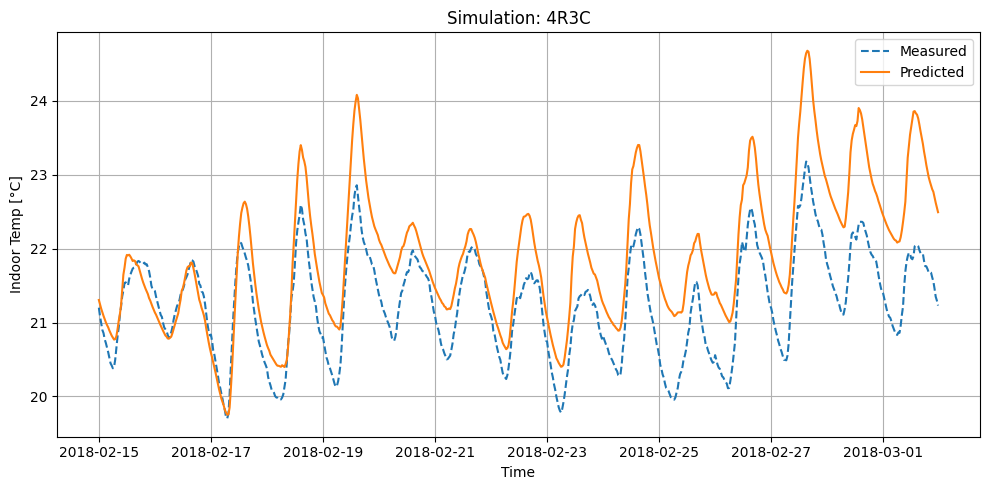

five last days Validation RMSE: 1.0992


In [3]:
from models import *  
from train import *  
import numpy as np
from simulate import *
from plot import *

train_cs2 = cs2.iloc[:240+480+480+480+480]
val_cs2 = cs2.iloc[240+480+480+480+480:-240]
test_cs2= cs2.iloc[240+480+480+480+480:]
# --- Bounds ---

bounds_cs2 = {
    "R_in_e": (0.001, 1),
    "R_e_a": (0.001, 1),
    "R_in_a": (0.001, 1),
    "C_in": (1e6, 5e8),
    "C_e": (1e6, 5e8),
    "Ain": (0.0001, 0.3 * cs2_surface_area),
    "Ae": (0.0001, 0.3 * cs2_surface_area),
    "fh": (0,1)
}

best_rmse = np.inf
best_params = None
best_initialization = None
best_initialization_validation = None
best_model = None
best_trial_index = -1
all_trials = pd.DataFrame()
solve_time = 0 
param_names = list(bounds_cs2.keys())

for i in range(10):
    model_3r2c_cs2_5days, all_trials_3r2c_cs2_5days, best_initialization_5days, parameters_5days = run_case_study(train_df=train_cs2, surface_area=cs2_surface_area, label="Case Study 2",model_type="4R3C", bounds=bounds_cs2, trials=1)
    last_index = max(model_3r2c_cs2_5days.T_in.index_set())
    # --- Validation Initialization (from last training value) ---
    initialize_validation = {"Tint": model_3r2c_cs2_5days.T_int[last_index](),"Tin": model_3r2c_cs2_5days.T_in[last_index](), "Te": model_3r2c_cs2_5days.T_e[last_index]()}

    # --- Run Simulation and Validation ---
    validation, t_pred_3r2c_cs2_5days, t_true_3r2c_cs2_5days = simulate_and_evaluate(
        val_df=val_cs2,
        param_dict=parameters_5days,
        model_type="4R3C",
        initializations=initialize_validation,
        show_plot=False
    )
    # --- Results ---   
    print(f"Validation RMSE: {validation['RMSE']:.4f}")
    
    if validation['RMSE'] < best_rmse:
        best_rmse=validation['RMSE']
        best_params=parameters_5days
        best_initialization=best_initialization
        best_model=model_3r2c_cs2_5days
        best_trial_index=i
        all_trials=all_trials_3r2c_cs2_5days
        best_initialization_validation = initialize_validation
        

print(f"Best RMSE: {best_rmse:.4f}")

# --- Run Simulation and Validation ---
validation, t_pred_3r2c_cs2_5days, t_true_3r2c_cs2_5days = simulate_and_evaluate(
        val_df=test_cs2,
        param_dict=best_params,
        model_type="4R3C",
        initializations=best_initialization_validation,
        show_plot=True
    )

rmse_3r2c_5days = np.sqrt(mean_squared_error(t_true_3r2c_cs2_5days[-240:], t_pred_3r2c_cs2_5days[-240:]))
print(f"five last days Validation RMSE: {rmse_3r2c_5days:.4f}")

# --- Plot Residuals ---
# plot_residual(t_pred=t_pred_3r2c_cs2_5days, t_true=t_true_3r2c_cs2_5days)
